# Further inspection of recordings showed a third frequency group

#### Before taking more sophisticated approaches towards frequency-based clustering, I felt it would be good to establish a few example recordings represetative of the kinds of frequencies I have observed.

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, EXAMPLE_FILES_from_LOCATIONS, EXAMPLE_FILES_to_FILEPATHS, EXAMPLE_FILES_to_DETECTIONS
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh

from cli import get_file_paths

### Below, red and yellow detections were both originally clustered together as HF calls.
### Blue detections were originally clustered together as LF calls

#### **A white dashed line has been included to show a potential frequency threshold to separate the yellow and red group.**
#### **Calls with min. frequency >= 43000 have been put into the yellow group.**
#### **As an update to the previous notebook, calls with min. frequency >= 35000 have been put into the red group**

In [153]:
site_key = 'Carp'
freq_key = ''
files = EXAMPLE_FILES_from_LOCATIONS[site_key]
thresh = -10
line_color = 'navy'
line_alpha = 0.002
reduce = 50
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = freq_key
data_params["dc_tag"] = "1800of1800"
data_params["cur_dc_tag"] = "1800of1800"

file_paths = get_file_paths(data_params)

filepath_key = files[9]
filename = filepath_key.split('/')[-1]
file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate

csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'])
location_sum_df = dh.assemble_initial_location_summary(data_params, file_paths) 
bout_params = bt_clustering.get_bout_params_from_location(location_sum_df, data_params)
batdetect2_preds_with_bouttags = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)

In [160]:
df1 = location_sum_df.loc[location_sum_df['freq_group']=='LF1'].copy()

In [161]:
df1['call_durations'] = (df1['call_end_time'] - df1['call_start_time'])

In [162]:
(df1['call_durations']).max()

Timedelta('0 days 00:00:00.034100')

In [165]:
df1.loc[df1['call_durations']==(df1['call_durations']).max()]

,freq_group,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,call_durations
3,LF1,2022-08-10 10:05:14.440500,2022-08-10 10:05:14.440500,2022-08-10 10:05:14.474600,314.4405,314.4746,16875.0,20353.0,Echolocation,Nyctalus noctula,0.56,0.643,-1,/mnt/ubna_data_01/recover-20220811/UBNA_007/20...,Carp Pond,<NA>,NaN,0 days 00:00:00.034100


In [5]:
def plot_audio_signal(audio_features):
    plt.figure(figsize=(8, 4))
    ft_size = 18
    plt.rcParams.update({'font.size': ft_size})
    plt.title(f"{audio_features['file_path'].name}", fontsize=ft_size-2)
    plt.plot(audio_features['audio_segment'])
    number_of_samples = audio_features['duration']*audio_features['sample_rate']

    plt.xticks(ticks=np.linspace(0, number_of_samples, 4), 
               labels=np.round(np.linspace(audio_features['start'], audio_features['end'], 4, dtype='float'), 2), rotation=30)
    plt.xlim(0, number_of_samples)
    plt.ylabel("Volts (V)")
    plt.xlabel("Time (s)")
    plt.grid(which='both')
    plt.show()

def plot_cumulative_energy_of_audio_signal(audio_features):
    plt.figure(figsize=(8, 4))
    ft_size = 18
    plt.title(f"{audio_features['file_path'].name}", fontsize=ft_size-2)
    cum_energy = np.cumsum(audio_features['audio_segment']**2)
    cum_energy_percent = 100*(cum_energy/cum_energy.max())
    number_of_samples = audio_features['duration']*audio_features['sample_rate']
    time_of_signal = np.linspace(0, number_of_samples, int(number_of_samples))
    plt.plot(time_of_signal, cum_energy_percent)
    plt.xticks(ticks=np.linspace(0, number_of_samples, 4), 
               labels=np.round(np.linspace(audio_features['start'], audio_features['end'], 4, dtype='float'), 2), rotation=30)
    plt.xlim(0, number_of_samples)
    plt.axhline(y=5, linestyle='dashed', color='k')
    plt.axhline(y=95, linestyle='dashed', color='k')
    plt.axvline(x=time_of_signal[cum_energy_percent<=5][-1], linestyle='dashed', color='k')
    plt.axvline(x=time_of_signal[cum_energy_percent>=95][0], linestyle='dashed', color='k')
    plt.ylabel("Cum. Energy (%)")
    plt.xlabel("Time (s)")
    plt.grid(which='both')
    plt.show()

def plot_fft_spectrum_of_signal(audio_features, snr):
    fs = audio_features['sample_rate']
    number_of_samples = audio_features['duration']*fs
    plt.figure(figsize=(8, 4))
    ft_size = 18
    plt.title(f"{audio_features['file_path'].name}", fontsize=ft_size-2)
    fft_signal = audio_features['audio_segment']
    time_of_signal = np.arange(0, len(fft_signal))
    plt.plot(time_of_signal, fft_signal, label=f'SNR = {round(snr, 1)}')
    plt.xticks(ticks=np.linspace(0, number_of_samples/2, 9), labels=np.linspace(0, fs/2000, 9, dtype='int'), rotation=45)
    plt.xlim(0, number_of_samples/2)
    plt.ylabel("FFT Magnitude (dB)")
    plt.xlabel("Frequency (kHz)")
    plt.legend(fontsize=16, loc='upper right')
    plt.grid(which='both')
    plt.show()

def plot_spectrogram_of_signal(audio_features, spec_features, row):
    plt.figure(figsize=(8, 4))
    ft_size = 18
    plt.rcParams.update({'font.size': ft_size})
    plt.title(f"{audio_features['file_path'].name}", fontsize=ft_size-2)
    vmin = 20*np.log10(np.max(audio_features['audio_segment'])) - reduce # hide anything below -rm_dB dB
    fs = audio_features['sample_rate']
    number_of_samples = audio_features['duration']*audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']
    plt.specgram(audio_features['audio_segment'], NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=vmin)
    ax = plt.gca()
    rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=4, edgecolor='yellow', facecolor='none', alpha=0.8)
    ax.add_patch(rect)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, number_of_samples/2, 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 3), rotation=30)
    
    plt.xlim(0, number_of_samples//2)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()

In [6]:
i = np.random.randint(len(batdetect2_predictions))
row = batdetect2_predictions.iloc[i]
batdetect2_predictions.iloc[i:i+1]

,start_time_wrt_ref,end_time_wrt_ref,freq_group,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event,input_file,Site name,Recover Folder,SD Card
1051,1712.7085,1712.7165,HF1,2022-08-02 09:00:00,2022-08-02 09:28:32.708500,2022-08-02 09:28:32.716500,1712.7085,1712.7165,39218.0,53816.0,Pipistrellus nathusii,0.493,0.621,-1,Echolocation,/mnt/ubna_data_01/recover-20220804/UBNA_002/20...,Foliage,recover-20220804,2


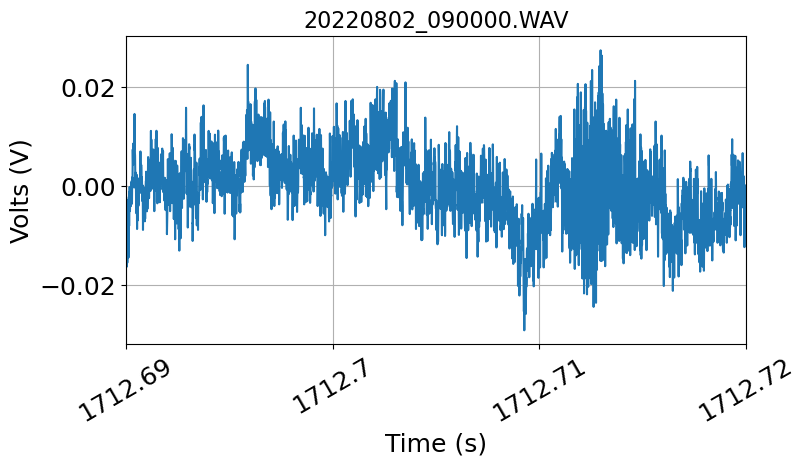

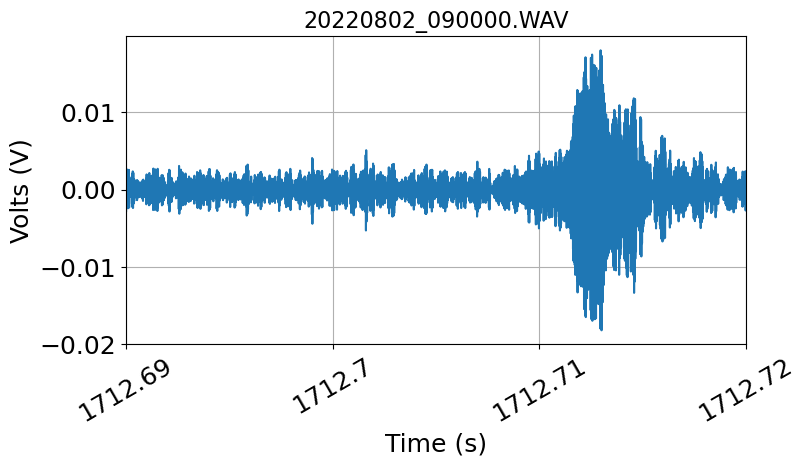

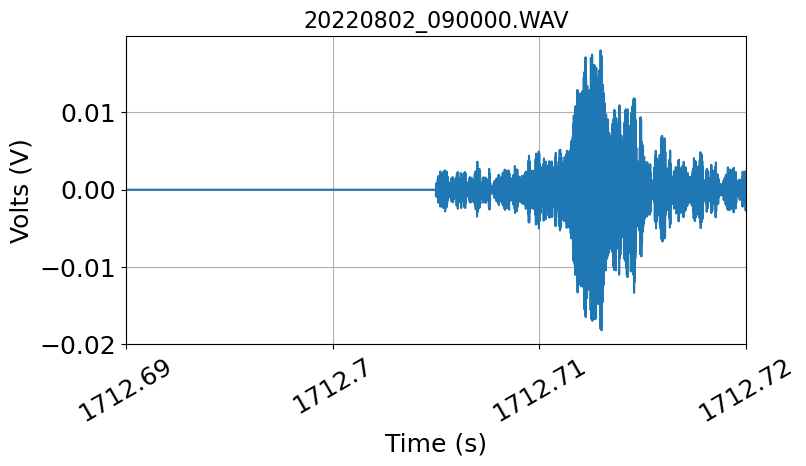

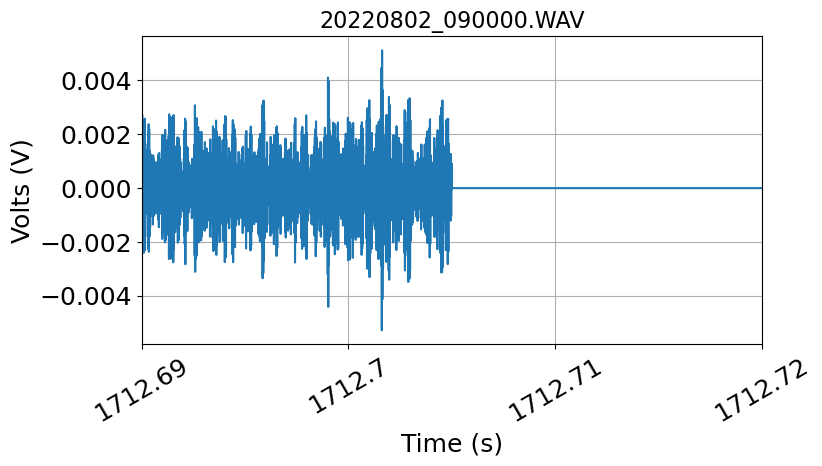

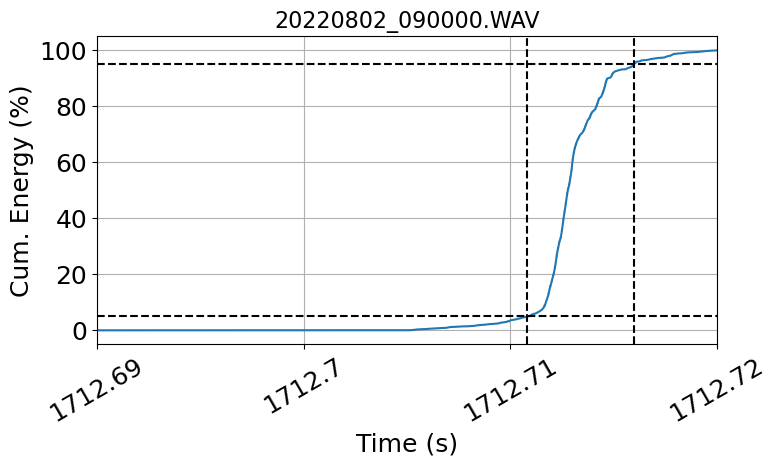

In [7]:
########################################################################################################
############### BELOW WE READ IN THE WINDOW OF DETECTION OF THE AUDIO WE ARE CONSIDERING ###############
########################################################################################################
call_dur = (row['end_time'] - row['start_time'])
pad = 0.002
start = row['start_time'] - call_dur - (3*pad)
duration = (2 * call_dur) + (4*pad)
end = row['end_time']

audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))

audio_features = dict()
audio_features['start'] = start
audio_features['end'] = end
audio_features['duration'] = duration
audio_features['audio_segment'] = audio_seg
audio_features['sample_rate'] = audio_file.samplerate
audio_features['file_path'] = file_path
plot_audio_signal(audio_features)

################################################################################################
############### BELOW WE APPLY A BANDPASS FILTER ON THE AUDIO WE ARE CONSIDERING ###############
################################################################################################
nyq = 0.5 * fs
low_cutoff = (row['low_freq'] - 2000)/ nyq
high_cutoff =  (row['high_freq'] + 2000) / nyq
b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
band_limited_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)
audio_features['audio_segment'] = band_limited_audio_seg
plot_audio_signal(audio_features)

######################################################################################
############### BELOW WE PLOT THE AUDIO WE ARE CONSIDERING AS OUR CALL ###############
######################################################################################
signal = band_limited_audio_seg.copy()
signal[:int(fs*(call_dur+(2*pad)))] = 0
audio_features['audio_segment'] = signal
plot_audio_signal(audio_features)

######################################################################################
############### BELOW WE PLOT THE AUDIO WE ARE CONSIDERING AS OUR CALL ###############
######################################################################################
noise = band_limited_audio_seg - signal
audio_features['audio_segment'] = noise
plot_audio_signal(audio_features)

###################################################################################################
############### BELOW WE PLOT THE CUMULATIVE ENERGY OF THE AUDIO WE ARE CONSIDERING ###############
###################################################################################################
audio_features['audio_segment'] = signal
plot_cumulative_energy_of_audio_signal(audio_features)

In [30]:
def plot_fft_spectrum_of_signal(audio_features, snr):
    fs = audio_features['sample_rate']
    plt.figure(figsize=(8, 4))
    ft_size = 18
    plt.title(f"{audio_features['file_path'].name}", fontsize=ft_size-2)
    fft_signal = audio_features['audio_segment']
    time_of_signal = np.arange(0, len(fft_signal))
    plt.plot(time_of_signal, fft_signal, label=f'SNR = {round(snr, 1)}')
    plt.xticks(ticks=np.linspace(0, fs/2, 9), labels=np.linspace(0, fs/2000, 9, dtype='int'), rotation=45)
    plt.xlim(0, fs/2)
    plt.ylabel("FFT Magnitude (dB)")
    plt.xlabel("Frequency (kHz)")
    plt.legend(fontsize=16, loc='upper right')
    plt.grid(which='both')
    plt.show()

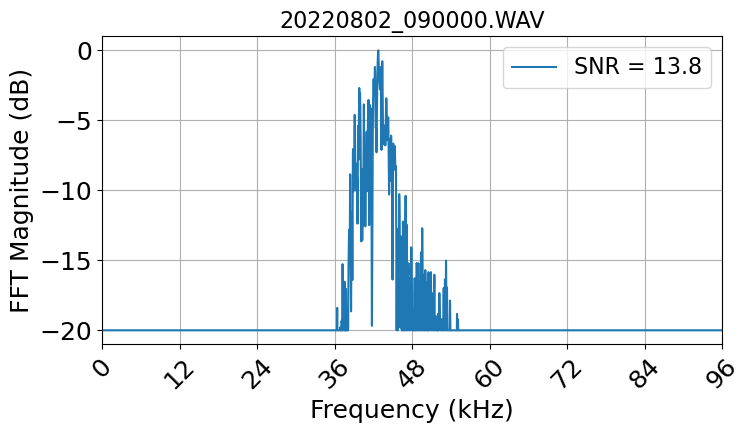

In [67]:
#####################################################################################
############### BELOW WE PLOT THE FFT OF THE AUDIO WE ARE CONSIDERING ###############
#####################################################################################
cleaned_call_signal = signal[-int(fs*(call_dur+(2*pad))):]
signal_power = np.sqrt(np.square(cleaned_call_signal).mean())
noise_power = np.sqrt(np.square(noise).mean())
snr = abs(20 * np.log10(signal_power / noise_power))

coeff = fs
audio_spectrum = scipy.fft.rfft(signal, n=coeff)
audio_spectrum_mag = np.abs(audio_spectrum)
audio_spectrum_db =  20*np.log10(audio_spectrum_mag)
normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

thresh = -20
peak_mag = np.zeros(len(normalized_audio_spectrum_db))+thresh
peak_mag[normalized_audio_spectrum_db>=thresh] = normalized_audio_spectrum_db[normalized_audio_spectrum_db>=thresh]
audio_features['audio_segment'] = peak_mag
fs = audio_features['sample_rate']
plt.figure(figsize=(8, 4))
ft_size = 18
plt.title(f"{audio_features['file_path'].name}", fontsize=ft_size-2)
fft_signal = audio_features['audio_segment']
freqs_of_signal = np.arange(0, len(fft_signal))
plt.plot(freqs_of_signal, fft_signal, label=f'SNR = {round(snr, 1)}')
plt.xticks(ticks=np.linspace(0, coeff/2, 9), labels=np.linspace(0, fs/(2000), 9, dtype='int'), rotation=45)
plt.xlim(0, coeff/2)
plt.ylabel("FFT Magnitude (dB)")
plt.xlabel("Frequency (kHz)")
plt.legend(fontsize=16, loc='upper right')
plt.grid(which='both')
plt.show()

In [116]:
#####################################################################################
############### BELOW WE PLOT THE FFT OF THE AUDIO WE ARE CONSIDERING ###############
#####################################################################################
cleaned_call_signal = signal[-int(fs*(call_dur+(2*pad))):]
signal_power = np.sqrt(np.square(cleaned_call_signal).mean())
noise_power = np.sqrt(np.square(noise).mean())
snr = abs(20 * np.log10(signal_power / noise_power))
signal.shape

(4608,)

In [177]:
coeff = 4096
audio_spectrum = scipy.fft.fft(signal, n=coeff)
audio_spectrum

array([-0.00117609-0.j        , -0.00013584-0.00020759j,
       -0.00101888+0.00037819j, ..., -0.0004265 +0.00050287j,
       -0.00101888-0.00037819j, -0.00013584+0.00020759j])

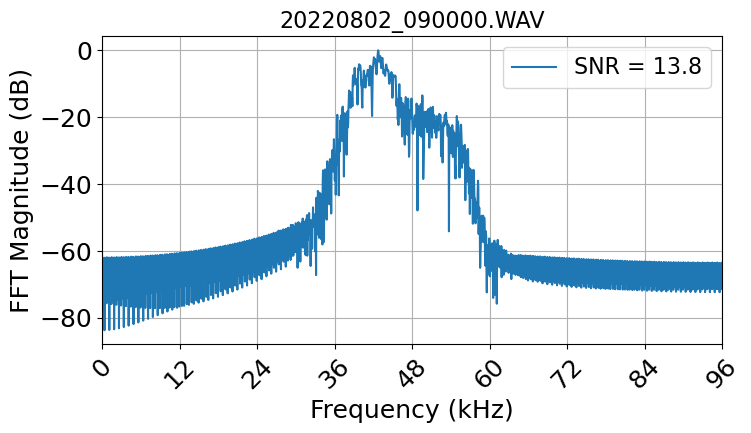

In [178]:
audio_spectrum_mag = np.abs(audio_spectrum)
audio_spectrum_db =  20*np.log10(audio_spectrum_mag)
normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

thresh = -100
peak_mag = np.zeros(len(normalized_audio_spectrum_db))+thresh
peak_mag[normalized_audio_spectrum_db>=thresh] = normalized_audio_spectrum_db[normalized_audio_spectrum_db>=thresh]

audio_features['audio_segment'] = peak_mag
fs = audio_features['sample_rate']
plt.figure(figsize=(8, 4))
ft_size = 18
plt.title(f"{audio_features['file_path'].name}", fontsize=ft_size-2)
fft_signal = audio_features['audio_segment']
freqs_of_signal = np.arange(0, len(fft_signal))
plt.plot(freqs_of_signal, fft_signal, label=f'SNR = {round(snr, 1)}')
plt.xticks(ticks=np.linspace(0, coeff/2, 9), labels=np.linspace(0, fs/(2000), 9, dtype='int'), rotation=45)
plt.xlim(0, coeff/2)
plt.ylabel("FFT Magnitude (dB)")
plt.xlabel("Frequency (kHz)")
plt.legend(fontsize=16, loc='upper right')
plt.grid(which='both')
plt.show()

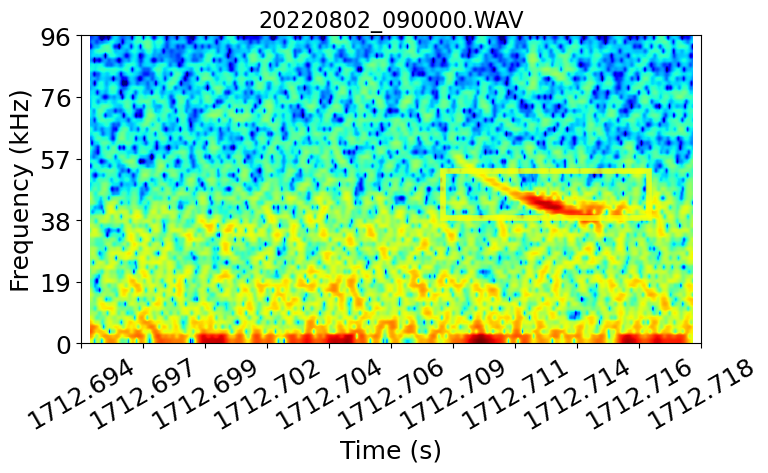

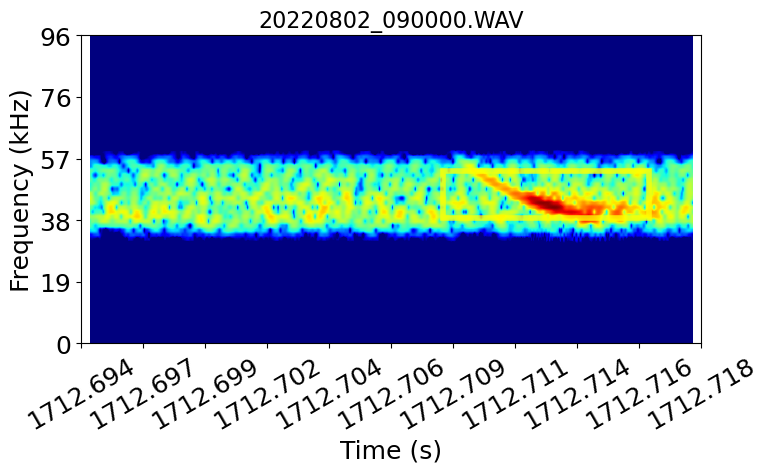

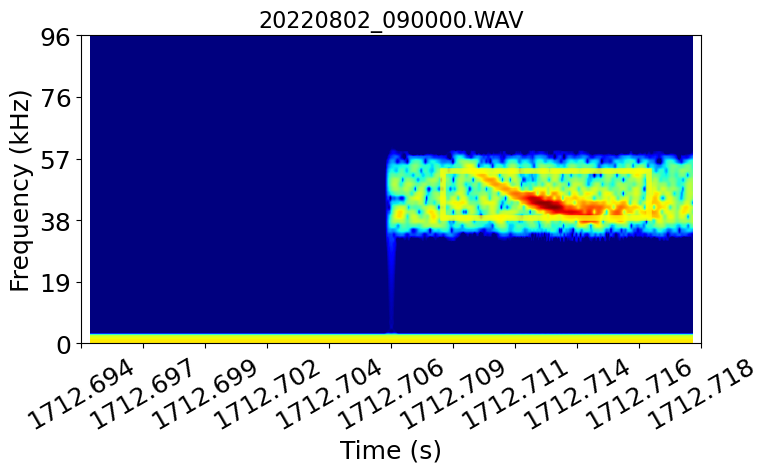

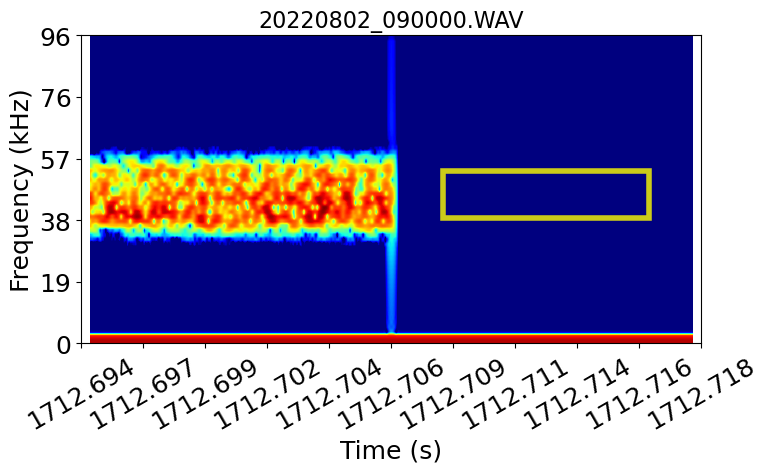

In [10]:
spec_features = dict()
spec_features['NFFT'] = 132
spec_features['cmap'] = 'jet'

audio_features['audio_segment'] = audio_seg
plot_spectrogram_of_signal(audio_features, spec_features, row)

audio_features['audio_segment'] = band_limited_audio_seg
plot_spectrogram_of_signal(audio_features, spec_features, row)

audio_features['audio_segment'] = signal+1e-3
plot_spectrogram_of_signal(audio_features, spec_features, row)

audio_features['audio_segment'] = noise+1e-3
plot_spectrogram_of_signal(audio_features, spec_features, row)

In [11]:
signal.shape

(4608,)

In [12]:
signal[signal!=0].shape

(2304,)

In [13]:
cleaned_call_signal.shape

(2304,)

In [14]:
noise[noise!=0].shape

(2304,)

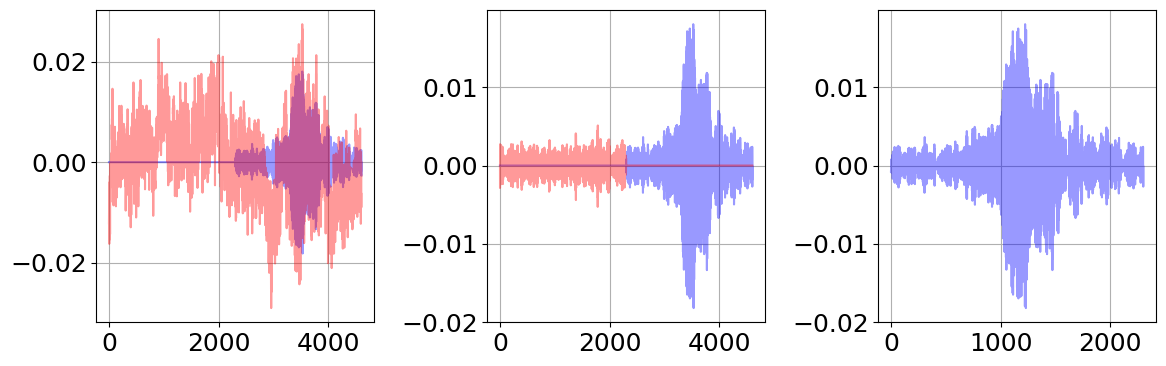

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(signal, color='blue', alpha=0.4)
plt.plot(audio_seg, color='red', alpha=0.4)
plt.grid(which='both')


plt.subplot(132)
plt.plot(signal, color='blue', alpha=0.4)
plt.plot(noise, color='red', alpha=0.4)
plt.grid(which='both')

plt.subplot(133)
plt.plot(cleaned_call_signal, color='blue', alpha=0.4)
plt.grid(which='both')

plt.tight_layout()
plt.show()

In [14]:
bout_index = np.random.randint(len(bout_metrics))
row = bout_metrics.iloc[bout_index]
bout_metrics.iloc[bout_index:bout_index+1]

,freq_group,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,bout_duration,bout_duration_in_secs
8,HF1,2022-08-02 09:01:35.128500,2022-08-02 09:01:36.352900,95.1285,96.3529,95.1285,96.3529,36640.0,57503.0,0 days 00:00:01.224400,1.2244


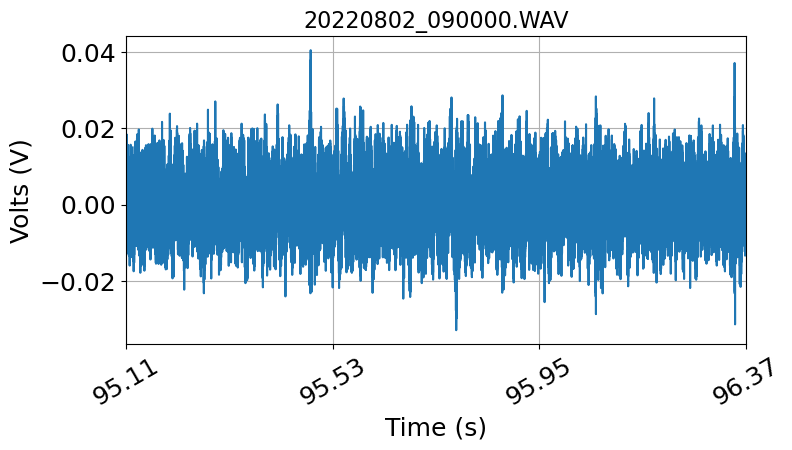

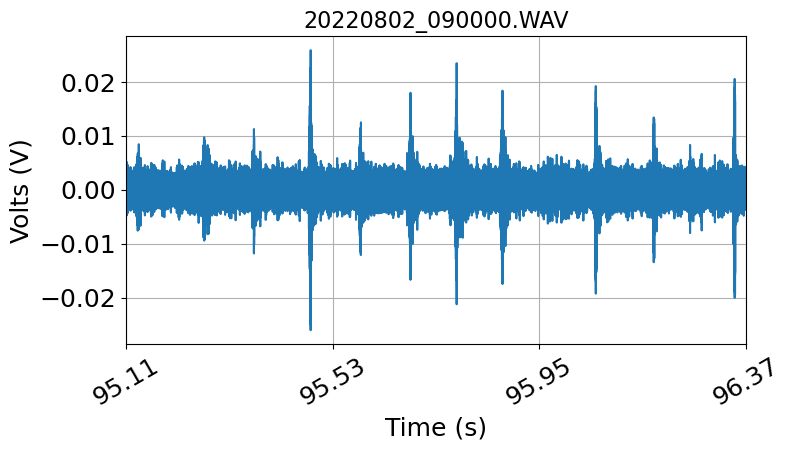

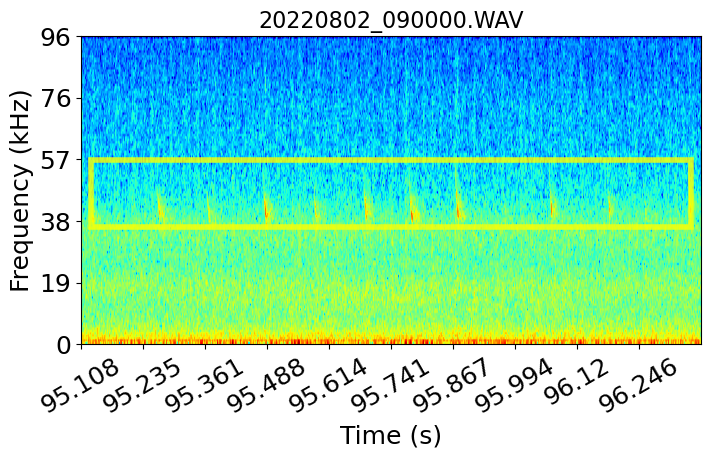

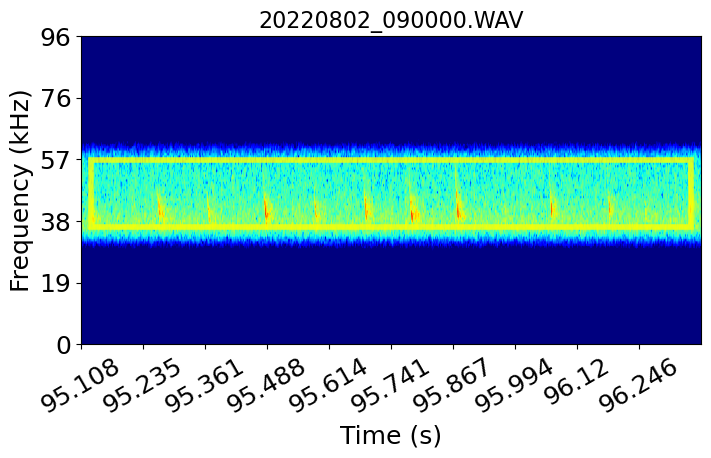

In [15]:
########################################################################################################
############### BELOW WE READ IN THE WINDOW OF DETECTION OF THE AUDIO WE ARE CONSIDERING ###############
########################################################################################################

start = row['start_time'] - 0.02
end = row['end_time'] + 0.02
duration = end - start
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))

audio_features = dict()
audio_features['start'] = start
audio_features['end'] = end
audio_features['duration'] = duration
audio_features['audio_segment'] = audio_seg
audio_features['sample_rate'] = audio_file.samplerate
audio_features['file_path'] = file_path
plot_audio_signal(audio_features)

################################################################################################
############### BELOW WE APPLY A BANDPASS FILTER ON THE AUDIO WE ARE CONSIDERING ###############
################################################################################################
nyq = 0.5 * fs
low_cutoff = (row['low_freq'] - 2000)/ nyq
high_cutoff =  (row['high_freq'] + 2000) / nyq
b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
band_limited_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)
audio_features['audio_segment'] = band_limited_audio_seg
plot_audio_signal(audio_features)

spec_features = dict()
spec_features['NFFT'] = 256
spec_features['cmap'] = 'jet'

audio_features['audio_segment'] = audio_seg
plot_spectrogram_of_signal(audio_features, spec_features, row)

audio_features['audio_segment'] = band_limited_audio_seg
plot_spectrogram_of_signal(audio_features, spec_features, row)